# Visualizing Omicron: COVID-19 Deaths vs. Cases

![South_Africa](South_Africa.png)

## Last updated: 2022-01-11

Please see https://github.com/rarnaout/Covidcycles for details.

## About this project

For most of the COVID-19 pandemic, the daily focus has been on the number of cases. This still seems to be true as the omicron wave hits.

But omicron on the whole has been much milder. For those who have been recently doubly or triple vaccinated and/or recently infected and are free from underlying comorbidities (of which the list is long), the risk of death is very small. The primary risk of this phase of the pandemic is of those not in the above groups getting sick all at once, overwhelming available hospital beds, while the healthcare workforce is itself depleted as workers quarantine or are at home suffering (usually mild) symptoms.

Here we explore an interesting way to visualize differences in the various waves of the pandemic: plotting deaths as a function of cases. 

**It suggests that omicron is indeed quite different.**

Below are plots for various countries. The function `plot_deaths_vs_cases`, also below, should be self-contained enough for you to copy and paste and use to plot data for any country you like.

The data is from https://github.com/owid/covid-19-data, specifically from JHU (public > data > jhu). The usual caveats apply, including completeness from some countries and deaths with vs. of COVID-19 (incidental vs. causative).

Please use as you see fit, as long as it's with attribution.

Ramy Arnaout, MD, DPhil / Boston, MA / January 8, 2022

In [1]:
# %matplotlib notebook

import warnings
warnings.filterwarnings("ignore")  # lzma

from colour import Color
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import matplotlib as mpl
import numpy as np
import pandas as pd

In [2]:
# get data (biweekly smooths the weekly peaks and troughs)
base_url = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/"
cases  = base_url + "biweekly_cases_per_million.csv"
deaths = base_url + "biweekly_deaths_per_million.csv"
df_cases  = pd.read_csv(cases)
df_deaths = pd.read_csv(deaths)

In [3]:
def plot_deaths_vs_cases(country="United States",
                         min_width = 1, max_width = 7,
                         width_scaling = 4, alpha_scaling = 0.5, font_scaling = 0.5,
                         width_between_peaks = 15,
                         fontsize=20,
                         figsize=(6,6),
                         get_data=False, labels=True, time_series=False, save=False, fmt="pdf",
                        ):
    # get data (biweekly smooths the weekly peaks and troughs)
#     if get_data:
#         base_url = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/"
#         cases  = base_url + "biweekly_cases_per_million.csv"
#         deaths = base_url + "biweekly_deaths_per_million.csv"
#         df_cases  = pd.read_csv(cases)
#         df_deaths = pd.read_csv(deaths)
    df = pd.DataFrame({
        "dates": df_cases['date'],
        "cases": df_cases[country],
        "deaths": df_deaths[country]
         })
    df = df.dropna()
    cases  = np.array(list(df.cases))
    deaths = np.array(list(df.deaths))
    dates  = np.array(list(df.dates))
    first_date = dates[0]
    last_date = dates[-1]
    L = len(df)
    #    
    # get case peaks; will use to color waves(="loops"="cycles")
    if max(cases) > 50: prominence = (50, float('inf'))
    else:   # special case (China)
        prominence = (10, float('inf'))
        width_between_peaks = 10
    peaks, _ = find_peaks(cases, prominence=prominence, width=width_between_peaks)
    if L - peaks[-1] > 50: peaks = np.append(peaks, L-1)  # if no end peak, make the end the peak
    peak_dates = dates[peaks]
    #
    # get troughs between peaks
    troughs, _ = find_peaks(-cases, prominence=(50, float('inf')), width=15) # note minus sign
    pairs_of_peaks = zip(peaks, peaks[1:])
    new_troughs = [0]
    for peak1, peak2 in pairs_of_peaks:
        troughs_between_peaks = []
        for trough in troughs:
            if peak1 < trough < peak2:
                troughs_between_peaks.append(trough)
        troughs_between_peaks = np.array(troughs_between_peaks)
        if len(troughs_between_peaks >= 1):
            trough = min(troughs_between_peaks, key=lambda ii: cases[ii])
        else: continue
        new_troughs.append(trough)
    troughs = new_troughs
    if L-1 not in peaks: troughs.append(L-1)
    troughs = np.array(troughs)
    trough_dates = dates[troughs]
    #
    # set cosmetics
    #     colors
    ref_colors = [ "black", "black", "slategrey", "indigo", "darkblue", "seagreen", "orange", "red"]
    ref_colors = [Color(i) for i in ref_colors]
    last_color = ref_colors.pop()
    inter_trough_widths = troughs[1:] - troughs[:-1]
    if troughs[-1] != L-1:
        inter_trough_widths = np.append(inter_trough_widths, L-troughs[-1])
    colors = []
    for inter_trough_width, color in zip(inter_trough_widths[::-1], ref_colors[::-1]): # note [::-1]
        colors += list(i.hex for i in last_color.range_to(color, inter_trough_width))
        last_color = Color(color)
    colors = colors[::-1]                                                   # reverses [::-1] above
    #     alphas and line widths
    alphas = [(i/L)**alpha_scaling for i in range(L)]
    widths = [(max_width-min_width)*(i/L)**width_scaling+min_width for i in range(L)]
    #
    # create figure
    plt.ion()
    fig_width, fig_height = figsize
    _ = plt.figure(figsize=(fig_width+save*1.5,fig_height))   # hack so labels etc. are in the figure
    #     line
    for i in range(L-1):
        plt.plot(cases[i:i+2], deaths[i:i+2], c=colors[i], linewidth=widths[i], alpha=alphas[i], 
                 solid_capstyle='round')
    #     labels
    if labels == True:
        for i in peaks:
            plt.text(cases[i], deaths[i], f"  {dates[i][2:]}",    # space(s) for readability; don't need century
                     color=colors[i], zorder=-1000, fontsize=max(1.1*fontsize*(i/L)**font_scaling, 7), 
                     alpha=alphas[i])
    #
    # apply cosmetics
    plt.xlabel("Biweekly cases per million", fontsize=20)
    plt.ylabel("Biweekly deaths per million", fontsize=20)
    plt.title(f"{country} Deaths vs. Cases,\n{first_date} to {last_date}", fontsize=fontsize)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(direction='out', length=10, width=2, labelsize=fontsize)
    ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
    if save:
        plt.tight_layout()
        _ = plt.savefig(f"Hi-res_country_plots/{country}_{dates[-1]}.{fmt}", transparent=True, format=fmt)
    plt.show()
    
    # optionally, also plot time series
    if time_series:
        # plot cases vs. time
        plt.figure(figsize=(6,3))
        plt.plot(dates, cases)
        plt.scatter(peak_dates, cases[peaks], c="tab:orange")
        plt.scatter(trough_dates, cases[troughs], c="tab:red")
        plt.xticks(dates[::200])
        plt.title(f"{country}, Cases vs. Time,\n{dates[0]} to {dates[-1]}", fontsize=20)
        plt.ylabel("Cases", fontsize=20)
        plt.show()
        # plot deaths vs. time
        plt.figure(figsize=(6,3))
        plt.plot(dates, deaths)
        plt.xticks(dates[::200])
        plt.title(f"{country}, Deaths vs. Time,\n{dates[0]} to {dates[-1]}", fontsize=20)
        plt.ylabel("Deaths", fontsize=20)
        plt.show()        
    
    return

Let's look at some examples. In all the plots:

- the most recent wave is red, 
- the previous wave is green, the one before that is blue, the one before that is purple, and

The line thickens slightly as it approaches the present day.

Note the differences in scale from plot to plot.

<a id='country_plots'></a>

## South Africa

South Africa had one of the earliest omicron waves.

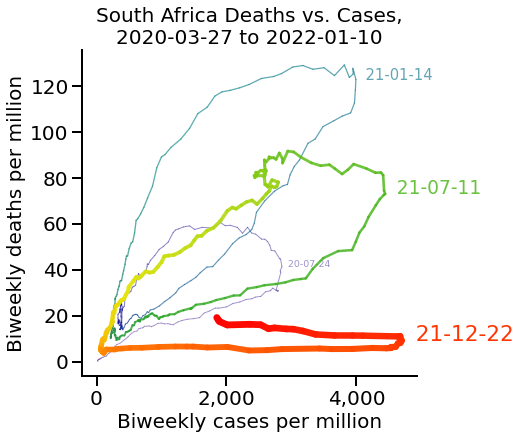

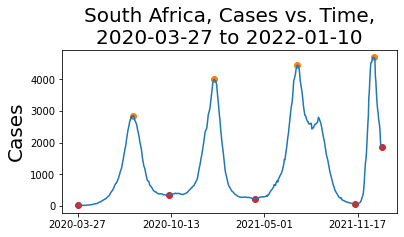

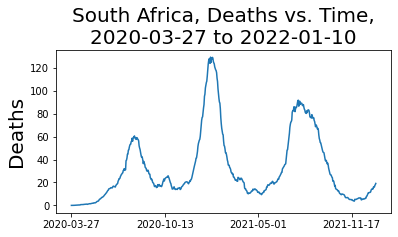

In [4]:
plot_deaths_vs_cases("South Africa", time_series=True)

Note the counterclockwise loops. Cases rise, then deaths rise, then cases fall, and finally deaths fall.

Original (purple), beta (blue), delta (green), and omicron (red) waves are clearly visible. Two mid-summer peaks, two mid-winter peaks.

The shape and area of each loop indicate the lag time between getting sick and dying, and also the deadliness of each wave.

The time series are shown for comparison, with peaks and troughs of cases denoted by orange and red dots.

The latest uptick at what was earlier described as the resolution of the omicron wave is worrisome and bears watching.

## Israel

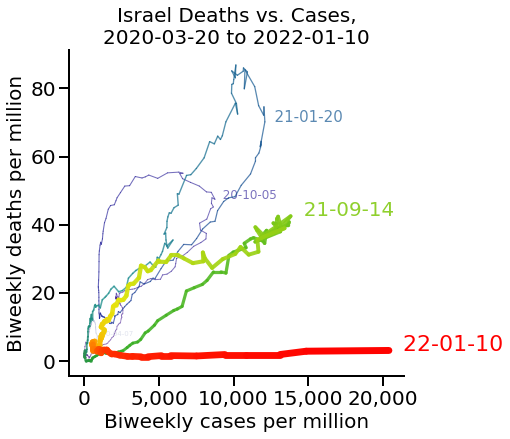

In [5]:
plot_deaths_vs_cases("Israel")

A highly vaccinated population. Omicron deaths are quite low. As with South Africa, note the flattening of subsequent waves, indicating progressive fall in case mortality.

## United States

Testing (and therefore the number of cases) has remained difficult to get and deaths have remained stubbornly high in the United States.

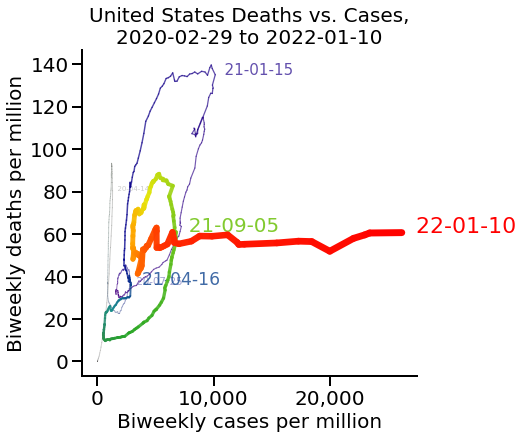

In [6]:
plot_deaths_vs_cases("United States")

The omicron wave has begun quite differently from previous waves. Hopefully it resolves as South Africa's has so far.

## Canada

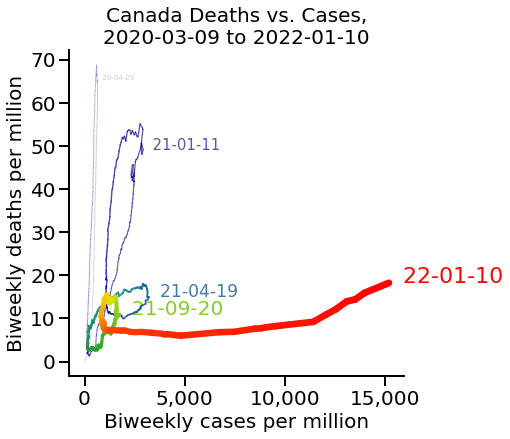

In [7]:
plot_deaths_vs_cases("Canada")

Similar dynamics to its neighbor to the south, but fewer cases and deaths per million.

## Italy

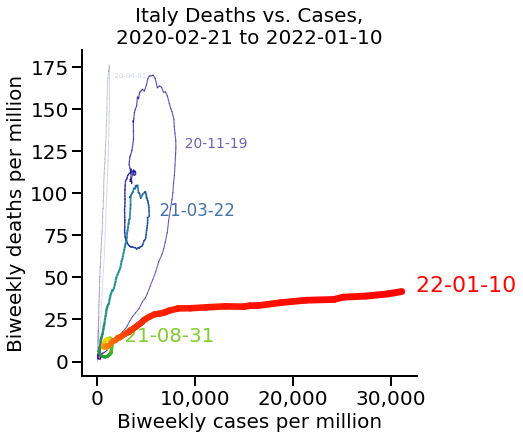

In [8]:
plot_deaths_vs_cases("Italy")

Famously hard-hit in the first wave. Note the April 2021 resurgence before the December 2020 peak had fully resolved, and how differently omicron has begun.

## Denmark

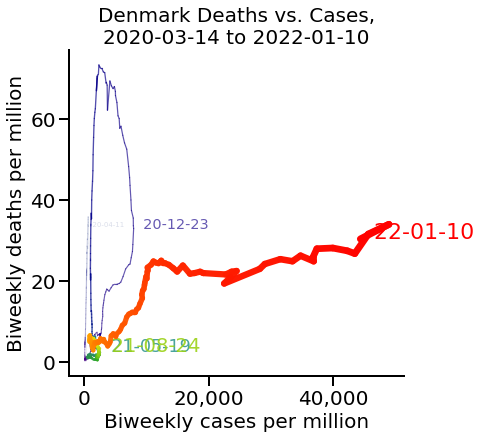

In [9]:
plot_deaths_vs_cases("Denmark")

A lot of virus sequencing in Denmark. A relatively quiet pandemic until omicron.

## United Kingdom

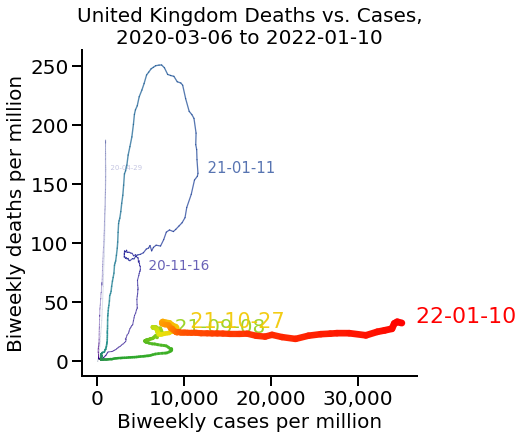

In [10]:
plot_deaths_vs_cases("United Kingdom")

A relatively mild delta wave.

## Sweden

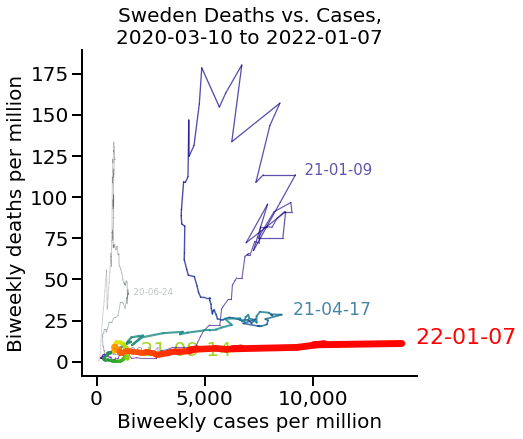

In [11]:
plot_deaths_vs_cases("Sweden")

Famously an outlier in its early approach. The spikiness suggests to me a data-reporting issue. A spike in April 2021.

## Germany

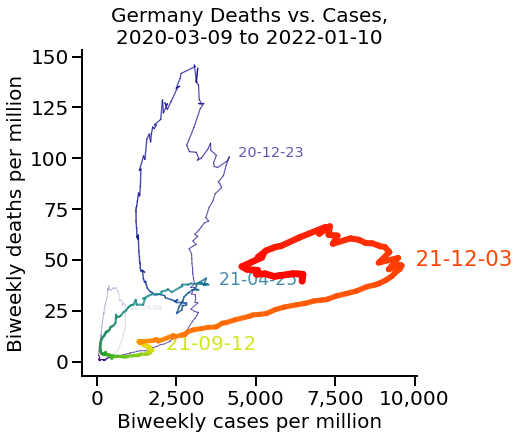

In [12]:
plot_deaths_vs_cases("Germany")

The second-most populous European country. Fewer loops, but again a dramatic difference in loop orientation, illustrating much different effect. Suspect omicron is yet to hit.

## Netherlands

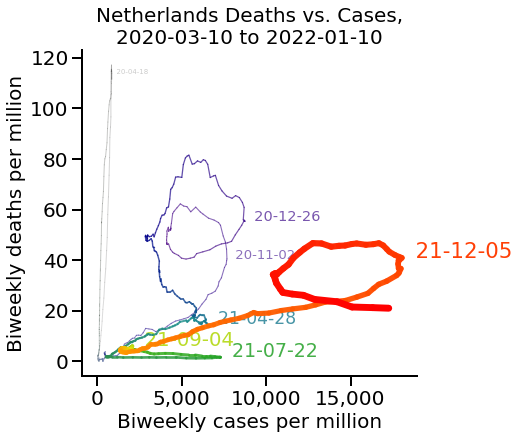

In [13]:
plot_deaths_vs_cases("Netherlands")

Good reporting. The green wave, which was dominated by the delta variant in other countries, was relatively mild compared to the current wave (red).

## Japan

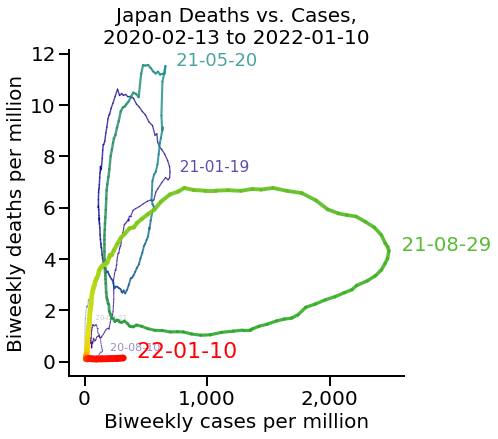

In [14]:
plot_deaths_vs_cases("Japan")

The August 2021 peak saw many more cases but many fewer deaths than the two previous ones. What changed for Japan between May and August? The omicron wave has yet to hit Japan... or if this is it, it is remarkable.

## South Korea

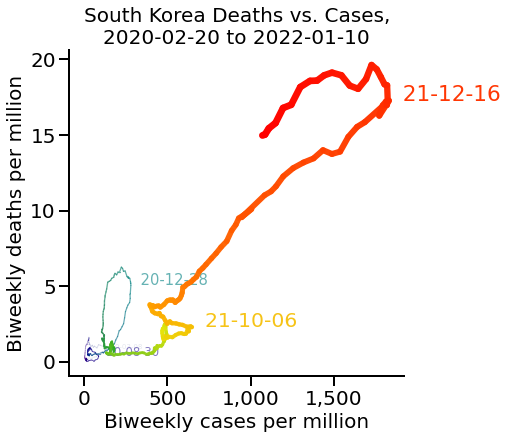

In [15]:
plot_deaths_vs_cases("South Korea")

Quite a different trajectory to its neighbors, but this is still delta. South Korea may well follow the Netherlands and Germany.

## China

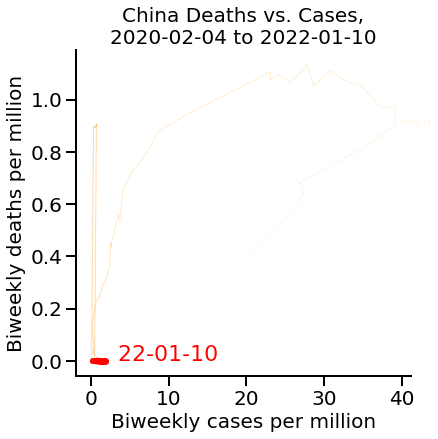

In [16]:
plot_deaths_vs_cases("China")

A zero-COVID policy. Very different trajectories. Note the axis units.

## India

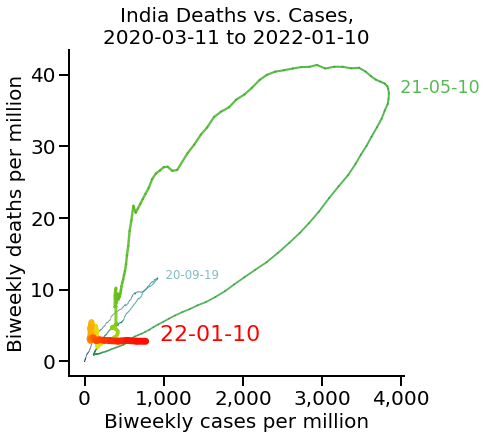

In [17]:
plot_deaths_vs_cases("India")

The second-most populous country.

## Australia

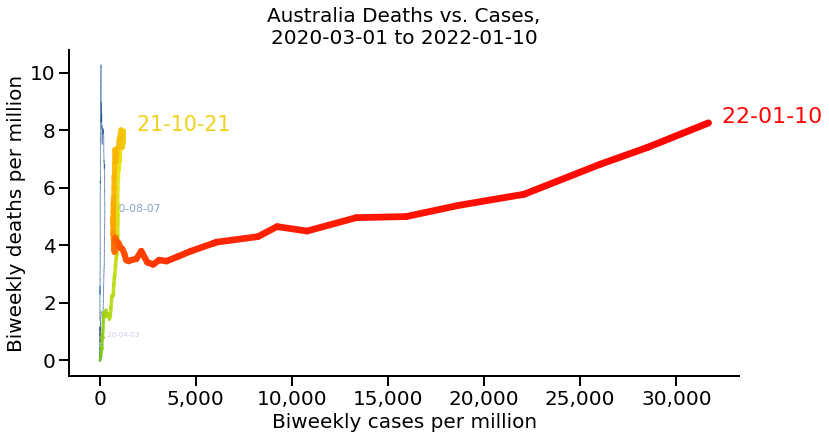

In [18]:
plot_deaths_vs_cases("Australia", figsize=(12, 6))

Another country with tight controls. In January 2021 Australia decided omicron was uncontainable. Expanded the x-axis to better see the previous loop.

## New Zealand

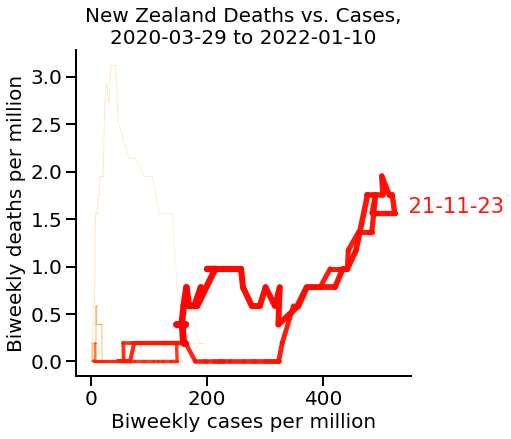

In [19]:
plot_deaths_vs_cases("New Zealand")

Small, distant, tight controls, unified populace, distinctive trajectories.

## World

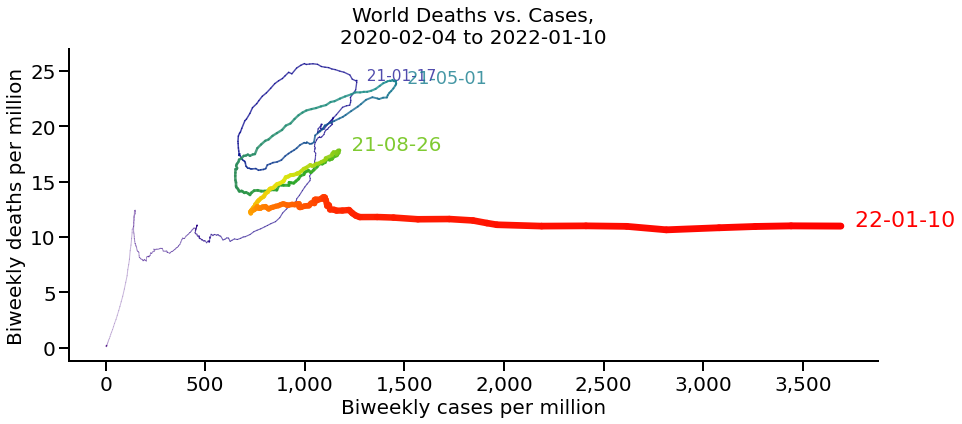

In [20]:
plot_deaths_vs_cases("World", save=True, figsize=(12,6))

All together now.